# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

2024-11-12 07:07:46.981432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0


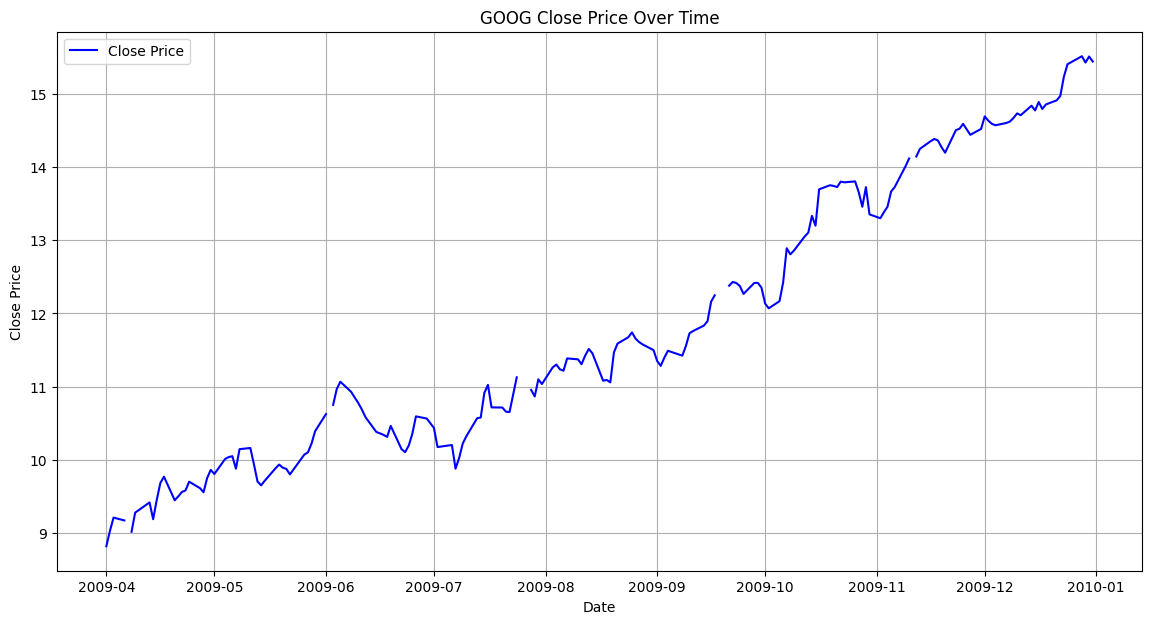

In [5]:
# Plot the Close Data

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title("GOOG Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
null_values = data.isnull().sum()

print("Null values in each column:\n", null_values)

Null values in each column:
 Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [7]:
# forward fill missing values
data.fillna(method='ffill', inplace=True)
display_df(data)

/tmp/ipykernel_13/3132433313.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0


In [8]:
# Check for null values
null_values = data.isnull().sum()
print("Null values in each column after forward fill:\n", null_values)

Null values in each column after forward fill:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


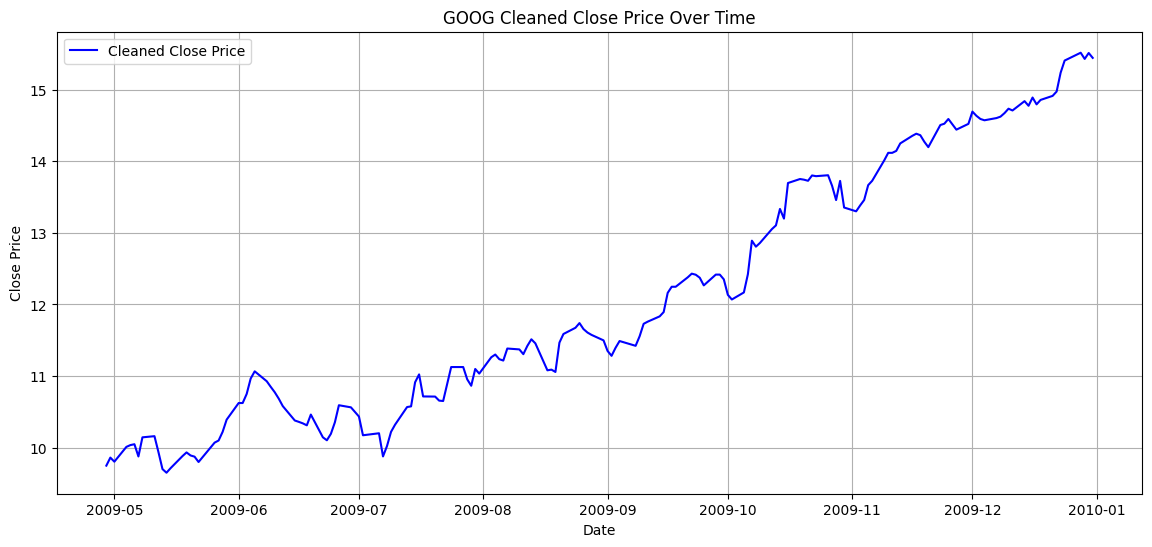

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Cleaned Close Price', color='blue')
plt.title("GOOG Cleaned Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [14]:
# Calculate 20-day bollinger bands
data['20_MA'] = data['Close'].rolling(window=20).mean()

# Calculate the 20-day standard deviation
data['20_STD'] = data['Close'].rolling(window=20).std()

# Calculate the Upper and Lower Bollinger Bands
data['Upper_Band'] = data['20_MA'] + (2 * data['20_STD'])
data['Lower_Band'] = data['20_MA'] - (2 * data['20_STD'])

# Display the updated DataFrame to confirm
display_df(data[['Close', '20_MA', 'Upper_Band', 'Lower_Band']])

,Close,20_MA,Upper_Band,Lower_Band
Date,,,,
2009-04-29,9.750204,NaN,NaN,NaN
2009-04-30,9.862284,NaN,NaN,NaN
2009-05-01,9.805497,NaN,NaN,NaN
2009-05-04,10.011973,NaN,NaN,NaN
2009-05-05,10.037128,NaN,NaN,NaN
2009-05-06,10.049084,NaN,NaN,NaN
2009-05-07,9.878224,NaN,NaN,NaN
2009-05-08,10.145223,NaN,NaN,NaN
2009-05-11,10.161413,NaN,NaN,NaN


In [15]:
# Remove rows with NaN bollinger bands
data.dropna(subset=['20_MA', 'Upper_Band', 'Lower_Band'], inplace=True)

# Display the cleaned DataFrame to confirm
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,20_MA,20_STD,Upper_Band,Lower_Band
Date,,,,,,,,,,
2009-05-27,10.103131,10.258050,10.082458,10.101138,10.101138,121826932.0,9.913293,0.150562,10.214417,9.612168
2009-05-28,10.178847,10.252073,10.077477,10.221687,10.221687,107152133.0,9.936867,0.160280,10.257427,9.616307
2009-05-29,10.264277,10.391799,10.229159,10.391799,10.391799,106325044.0,9.963343,0.188552,10.340447,9.586238
2009-06-01,10.429159,10.699894,10.424178,10.624178,10.624178,133394127.0,10.004277,0.235502,10.475280,9.533273
2009-06-02,10.429159,10.699894,10.424178,10.624178,10.624178,133394127.0,10.034887,0.273307,10.581501,9.488272
2009-06-03,10.610230,10.771127,10.560417,10.750953,10.750953,141841672.0,10.070578,0.316769,10.704116,9.437040
2009-06-04,10.841862,10.989808,10.821937,10.965897,10.965897,146069460.0,10.116419,0.374560,10.865540,9.367298
2009-06-05,11.085200,11.141738,10.945474,11.066520,11.066520,147783862.0,10.175833,0.425563,11.026959,9.324708
2009-06-08,10.946470,10.981837,10.812472,10.928288,10.928288,124412588.0,10.214987,0.457428,11.129842,9.300131


In [16]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'Upper_Band', 'Lower_Band']]

# Display the new dataset to confirm
display_df(dataset)

,Close,Upper_Band,Lower_Band
Date,,,
2009-05-27,10.101138,10.214417,9.612168
2009-05-28,10.221687,10.257427,9.616307
2009-05-29,10.391799,10.340447,9.586238
2009-06-01,10.624178,10.475280,9.533273
2009-06-02,10.624178,10.581501,9.488272
2009-06-03,10.750953,10.704116,9.437040
2009-06-04,10.965897,10.865540,9.367298
2009-06-05,11.066520,11.026959,9.324708
2009-06-08,10.928288,11.129842,9.300131


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

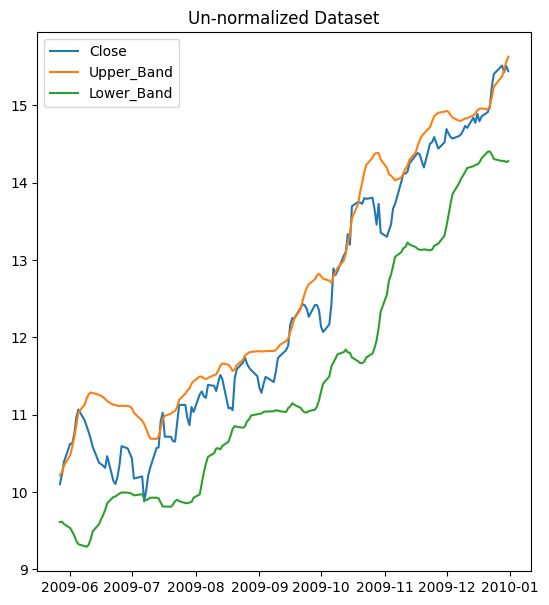

In [17]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(dataset, label=dataset.columns)
plt.title("Un-normalized Dataset")
plt.legend()
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

# Normalize Dataset
normlist = [] 
normed_dataset = pd.DataFrame(index=dataset.index)

for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]]  # Step 1: define column data as a DataFrame
    normed_column = normalizer.fit_transform(column_data)  # Step 2: fit and transform column data
    normed_dataset[col] = normed_column  # Step 3: add transformed data to normed_dataset
    normlist.append(normalizer)  # Step 4: append the fitted normalizer for future reference

Normalized Dataset:


,Close,Upper_Band,Lower_Band
Date,,,
2009-05-27,-1.362207,-1.543959,-1.152704
2009-05-28,-1.289113,-1.516542,-1.150048
2009-05-29,-1.185968,-1.463622,-1.169348
2009-06-01,-1.045068,-1.377673,-1.203344
2009-06-02,-1.045068,-1.309963,-1.232227
2009-06-03,-0.968199,-1.231804,-1.265111
2009-06-04,-0.837871,-1.128905,-1.309875
2009-06-05,-0.776859,-1.026010,-1.337211
2009-06-08,-0.860674,-0.960428,-1.352986


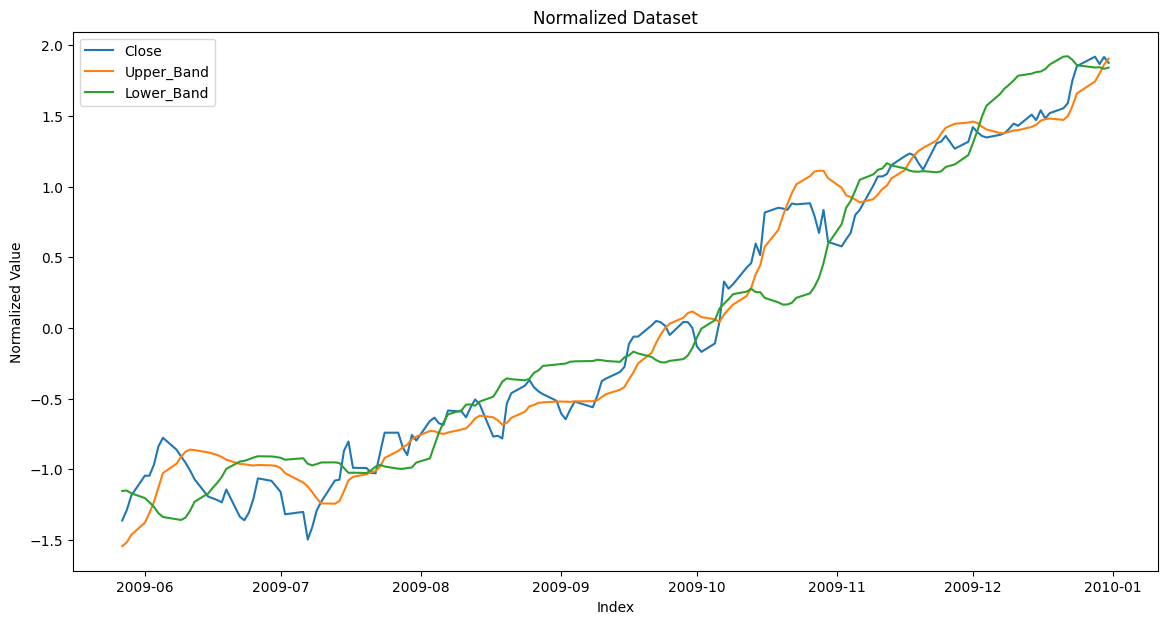

In [19]:
# Display normalized dataset
print("Normalized Dataset:")
display_df(normed_dataset)

# Plot normalized dataset
plt.figure(figsize=(14, 7))
for col in normed_dataset.columns:
    plt.plot(normed_dataset.index, normed_dataset[col], label=col)
plt.title("Normalized Dataset")
plt.xlabel("Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [20]:
train_size = len(normed_dataset) // 2  # Calculate half of the dataset size
train_df = normed_dataset.iloc[:train_size]  # First half for training
test_df = normed_dataset.iloc[train_size:]   # Second half for testing


In [21]:
# display train and test dfs (ensure no overlap)

print("Training DataFrame:")
display_df(train_df)
print("Testing DataFrame:")
display_df(test_df)

# Ensure no overlap between train and test sets by checking indices
overlap = train_df.index.intersection(test_df.index)
if overlap.empty:
    print("No overlap between train and test datasets.")
else:
    print("Overlap found in indices:", overlap)


Training DataFrame:


,Close,Upper_Band,Lower_Band
Date,,,
2009-05-27,-1.362207,-1.543959,-1.152704
2009-05-28,-1.289113,-1.516542,-1.150048
2009-05-29,-1.185968,-1.463622,-1.169348
2009-06-01,-1.045068,-1.377673,-1.203344
2009-06-02,-1.045068,-1.309963,-1.232227
2009-06-03,-0.968199,-1.231804,-1.265111
2009-06-04,-0.837871,-1.128905,-1.309875
2009-06-05,-0.776859,-1.026010,-1.337211
2009-06-08,-0.860674,-0.960428,-1.352986


Testing DataFrame:


,Close,Upper_Band,Lower_Band
Date,,,
2009-09-14,-0.311722,-0.436926,-0.239699
2009-09-15,-0.275175,-0.417235,-0.207331
2009-09-16,-0.112831,-0.362741,-0.193444
2009-09-17,-0.061031,-0.313217,-0.166976
2009-09-18,-0.061031,-0.250501,-0.180073
2009-09-21,0.018707,-0.175878,-0.204439
2009-09-22,0.049816,-0.105303,-0.227015
2009-09-23,0.040755,-0.047210,-0.242203
2009-09-24,0.015233,0.000135,-0.243882


No overlap between train and test datasets.


In [22]:
# Convert train and test DataFrames to numpy arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Track indices to remember which feature is which
idx_close = train_df.columns.get_loc("Close")      # Index of 'Close' column
idx_bb_upper = train_df.columns.get_loc("Upper_Band")  # Index of 'Upper_Band' column
idx_bb_lower = train_df.columns.get_loc("Lower_Band")  # Index of 'Lower_Band' column

# Output feature indices for reference
print("Index of 'Close' column:", idx_close)
print("Index of 'Upper_Band' column:", idx_bb_upper)
print("Index of 'Lower_Band' column:", idx_bb_lower)

Shape of X_train: (76, 3)
Shape of X_test: (77, 3)
Index of 'Close' column: 0
Index of 'Upper_Band' column: 1
Index of 'Lower_Band' column: 2


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

        
@keras.saving.register_keras_serializable()
class DQN(Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        # Define the input layer based on the state size
        self.input_layer = Input(shape=(state_size,))

        # Define the hidden layers with specified output shapes and activation functions
        self.hidden_layer1 = Dense(64, activation='relu')(self.input_layer)
        self.hidden_layer2 = Dense(32, activation='relu')(self.hidden_layer1)
        self.hidden_layer3 = Dense(8, activation='relu')(self.hidden_layer2)

        # Define the output layer with linear activation, matching the action space size
        self.output_layer = Dense(action_size, activation='linear')(self.hidden_layer3)

        # Build the model
        self.model = Model(inputs=self.input_layer, outputs=self.output_layer)

        # Compile the model using Mean Squared Error loss and Adam optimizer
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [38]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size
        self.num_features = num_features
        self.state_size = window_size * num_features
        self.action_size = 3  # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.test_mode = test_mode

        # Parameters for epsilon-greedy policy and model training
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    # Deep Q-Learning model initialization
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model

    # Get Q-values for a given state
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))

    # Fit model with state and target Q-values
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)

    # Act function for epsilon-greedy policy
    def act(self, state):
        if not self.test_mode and random.random() <= self.epsilon:
            return random.choice([0, 1, 2])  # Random action (0=hold, 1=buy, 2=sell)
        else:
            # Predict Q-values for the given state and choose the action with the highest Q-value
            q_values = self.get_q_values_for_state(state)
            return np.argmax(q_values[0])  # Return the index of the action with the highest Q-value

    # Experience Replay function
    def exp_replay(self, batch_size, losses):
        mini_batch = list(self.memory)[-batch_size:]  # Sequentially select last `batch_size` items
        losses = []


        for state, action, reward, next_state, done in mini_batch:
            # Calculate target Q-value
            if done:
                optimal_q_for_action = reward
            else:
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.max(next_q_values[0])

            # Get predicted Q-values for the current state
            target_q_table = self.get_q_values_for_state(state)
            # Update only the Q-value for the selected action
            target_q_table[0][action] = optimal_q_for_action

            # Train model on the updated Q-table
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [47]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

def get_state(data, current_index, window_size):
    # Ensure the state representation does not include the current day (t)
    start_index = max(0, current_index - window_size)
    state_data = data[start_index:current_index]  # Only include up to the previous day

    # Check if state_data is empty
    if state_data.shape[0] == 0:
        # Return a default state or handle the error as needed
        return np.zeros((3,))  # Assuming you want a state of size 3

    # Extract the most recent features (e.g., Close price and Bollinger Bands)
    close_price = state_data[-1, 0]  # Most recent Close price
    bollinger_band_upper = state_data[-1, 1]  # Most recent BB_upper
    bollinger_band_lower = state_data[-1, 2]  # Most recent BB_lower

    # Create state representation
    state = np.array([close_price, bollinger_band_upper, bollinger_band_lower])
    return state

### Training Loop

In [48]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set

# Display the shape of the training data
print("Shape of X_train:", X_train.shape)
print("Number of examples:", X_train.shape[0])
print("Number of features:", X_train.shape[1])

Shape of X_train: (76, 3)
Number of examples: 76
Number of features: 3


In [49]:
import keras.utils

# Disable Keras interactive logging to keep output clean
keras.utils.disable_interactive_logging()

# Define window size and instantiate the agent with the number of training features
window_size = 1
num_features = X_train.shape[1]  # Number of columns in X_train

# Instantiate the agent
agent = Agent(window_size=window_size, num_features=num_features)


In [50]:
# Track the number of examples in the dataset (i.e., number of days to train on)
l = X_train.shape[0]

# Set up batch size, episode count, and normalizers for inverse transformation
batch_size = 32
episode_count = 2

# Retrieve normalizers from normlist for the Close and Bollinger Bands values
normalizer_close = normlist[0]
normalizer_bb_upper = normlist[1]
normalizer_bb_lower = normlist[2]

# Inverse transform to get true prices and Bollinger Band values

# Assuming X_train is a NumPy array
X_train_true_price = normalizer_close.inverse_transform(X_train[:, 0].reshape(-1, 1))  # For 'Close'
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, 1].reshape(-1, 1))  # For 'BB_upper'
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, 2].reshape(-1, 1))  # For 'BB_lower'

#X_train_true_price = normalizer_close.inverse_transform(X_train[:, 0].reshape(-1, 1))

#X_train_true_price = normalizer_close.inverse_transform(X_train[['Close']].values)
#X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[['BB_upper']].values)
#X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[['BB_lower']].values)

# Initialize tracking variables for losses and episodes
batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, window_size - 1, window_size + 1)  # Get the state for the first step
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in tqdm(range(l - 1), desc=f'Running episode {e}/{episode_count}'):  # Iterate up to the second-to-last element
        action = agent.act(state)
        next_state = get_state(X_train, t + 1, window_size + 1)

        reward = 0  # Initialize reward

        if action == 1:  # Buy
            buy_price = normalizer_close.inverse_transform([[X_train[t, 0]]])[0][0]  # 0 for 'Close'
            agent.inventory.append(buy_price)
            states_buy.append(t)
            print(f"Buy: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0:  # Sell
            bought_price = agent.inventory.pop(0)
            sell_price = normalizer_close.inverse_transform([[X_train[t, 0]]])[0][0]  # 0 for 'Close'
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit

            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit

            states_sell.append(t)
            print(f"Sell: {format_price(sell_price)}, Profit: {format_price(trade_profit)}")

        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)]) if batch_losses else 0}')
            print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        if len(agent.memory) > batch_size:
            batch_loss = agent.exp_replay(batch_size, batch_losses)
            batch_losses.extend(batch_loss)

    if e % 2 == 0:
        agent.model.save(f'model_ep{e}.keras')

Running episode 0/2:   0%|          | 0/75 [00:00<?, ?it/s]

Buy: $10.62
Buy: $10.75
Buy: $10.93
Sell: $10.85, Profit: $0.23
Sell: $10.68, Profit: -$0.07
Sell: $10.58, Profit: -$0.35
Buy: $10.38
Sell: $10.36, Profit: -$0.02
Buy: $10.31
Sell: $10.46, Profit: $0.15
Buy: $10.15
Buy: $10.10
Sell: $10.50, Profit: $0.35
Buy: $10.17
Buy: $9.88
Sell: $10.22, Profit: $0.12
Buy: $10.57
Buy: $10.91
Buy: $11.02
Sell: $10.71, Profit: $0.54
Buy: $10.66
Buy: $11.13
Sell: $10.87, Profit: $0.99
Sell: $11.10, Profit: $0.53
Sell: $11.03, Profit: $0.12
Sell: $11.30, Profit: $0.28
Buy: $11.22
Buy: $11.38
Buy: $11.31
Buy: $11.42
Sell: $11.51, Profit: $0.86
Sell: $11.46, Profit: $0.33
Sell: $11.08, Profit: -$0.14
Sell: $11.09, Profit: -$0.29
Sell: $11.59, Profit: $0.28
Buy: $11.67
Sell: $11.74, Profit: $0.32
Sell: $11.66, Profit: -$0.02
Buy: $11.56
Sell: $11.73, Profit: $0.17


Running episode 1/2:   0%|          | 0/75 [00:00<?, ?it/s]

Buy: $10.22
Sell: $10.39, Profit: $0.17
Buy: $10.62
Sell: $10.75, Profit: $0.13
Buy: $10.31
Sell: $10.46, Profit: $0.15
Buy: $10.10
Sell: $10.19, Profit: $0.09
Buy: $10.50
Sell: $10.44, Profit: -$0.06
Buy: $10.20
Buy: $9.88
Buy: $10.32
Sell: $10.57, Profit: $0.37
Buy: $10.58
Sell: $10.91, Profit: $1.03
Buy: $11.02
Buy: $10.72
Buy: $10.71
Sell: $10.65, Profit: $0.33
Sell: $10.89, Profit: $0.32
Buy: $11.13
Sell: $11.10, Profit: $0.08
Sell: $11.26, Profit: $0.55
Sell: $11.30, Profit: $0.59
Sell: $11.24, Profit: $0.11
Buy: $11.58
Sell: $11.35, Profit: -$0.22
Buy: $11.28
Sell: $11.49, Profit: $0.21


Running episode 2/2:   0%|          | 0/75 [00:00<?, ?it/s]

Buy: $10.22
Buy: $10.39
Sell: $10.62, Profit: $0.40
Sell: $10.62, Profit: $0.23
Buy: $10.85
Sell: $10.77, Profit: -$0.08
Buy: $10.68
Buy: $10.58
Buy: $10.38
Buy: $10.36
Sell: $10.34, Profit: -$0.34
Sell: $10.31, Profit: -$0.27
Sell: $10.46, Profit: $0.08
Sell: $10.15, Profit: -$0.22
Buy: $10.10
Sell: $10.19, Profit: $0.09
Buy: $10.91
Sell: $10.72, Profit: -$0.20
Buy: $10.71
Buy: $10.66
Sell: $11.13, Profit: $0.41
Buy: $11.26
Sell: $11.22, Profit: $0.56
Sell: $11.38, Profit: $0.12
Buy: $11.42
Sell: $11.51, Profit: $0.09


### Plot Training Loss

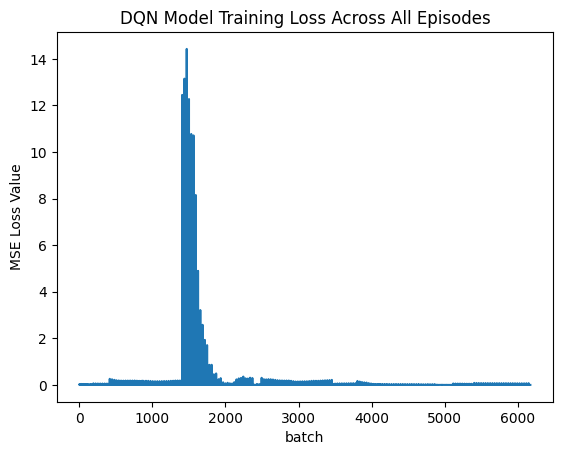

In [51]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "DQN Model Training Loss Across All Episodes")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [53]:
# Define Parameters
l_test = len(X_test) - 1
state = get_state(X_test, window_size, window_size + 1)  # Get the first state of the test dataset
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

# Get the true prices and Bollinger Band values for the test set
X_test_true_price = normalizer_close.inverse_transform(X_test[:, 0].reshape(-1, 1))  # For 'Close'
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, 1].reshape(-1, 1))  # For 'BB_upper'
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, 2].reshape(-1, 1))  # For 'BB_lower'

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Initial state shape: (3,)
Buy: $12.81
Buy: $12.86
Buy: $13.05
Buy: $13.10
Buy: $13.33
Buy: $13.20
Buy: $13.69
Buy: $13.75
Buy: $13.74
Buy: $13.73
Buy: $13.80
Buy: $13.79
Buy: $13.80
Buy: $13.66
Buy: $13.46
Buy: $13.72
Buy: $13.35
Buy: $13.30
Buy: $13.38
Buy: $13.46
Buy: $13.67
Buy: $13.73
Buy: $14.01
Buy: $14.12
Buy: $14.12
Buy: $14.14
Buy: $14.25
Buy: $14.35
Buy: $14.38
Buy: $14.36
Buy: $14.27
Buy: $14.20
Buy: $14.50
Buy: $14.52
Buy: $14.59
Buy: $14.44
Buy: $14.52
Buy: $14.69
Buy: $14.63
Buy: $14.59
Buy: $14.57
Buy: $14.60
Buy: $14.62
Buy: $14.67
Buy: $14.73
Buy: $14.71
Buy: $14.84
Buy: $14.77
Buy: $14.89
Buy: $14.79
Buy: $14.85
Buy: $14.91
Buy: $14.97
Buy: $15.23
Buy: $15.40
Buy: $15.51
Buy: $15.43
Buy: $15.51
------------------------------------------
Total Profit: $0.00
------------------------------------------


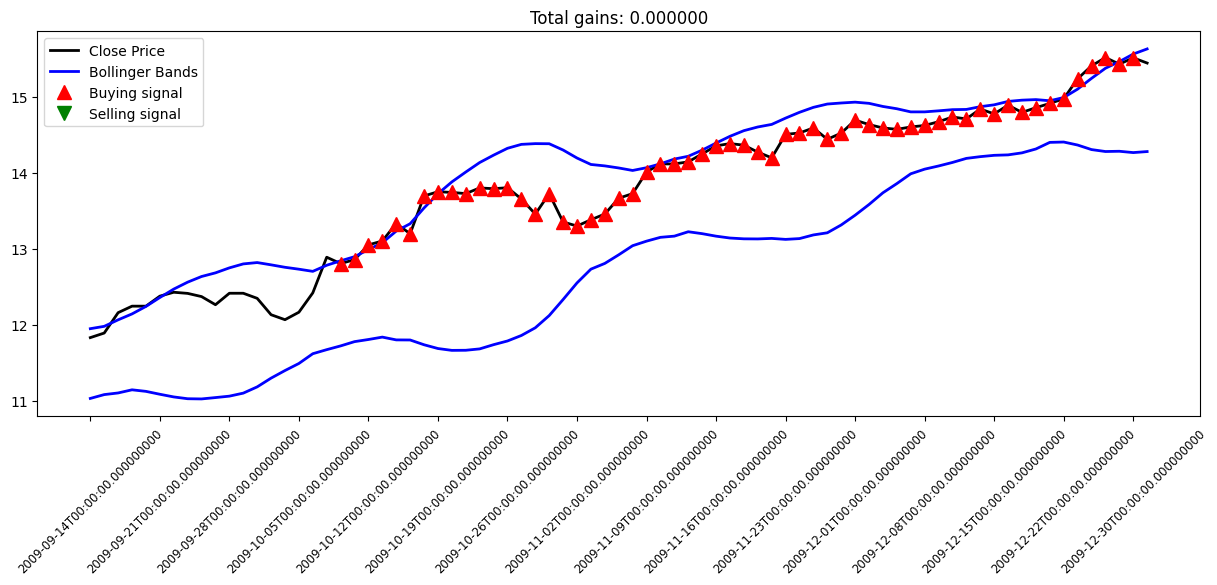

In [54]:
# Test the agent on the test dataset
total_profit = 0
states_sell_test = []
states_buy_test = []
l_test = len(X_test) - 1  # Length of the test dataset

state = get_state(X_test, window_size, window_size + 1)  # Get the initial state of the test dataset
print("Initial state shape:", state.shape)  # Check the shape of the initial state

for t in range(l_test):
    action = agent.act(state)  # Call to the agent's act method
    next_state = get_state(X_test, t + 1, window_size + 1)  # Get the next state in the test dataset

    reward = 0

    if action == 1:  # Buy
        buy_price = normalizer_close.inverse_transform(X_test[t, 0].reshape(-1, 1))[0][0]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0:  # Sell
        bought_price = agent.inventory.pop(0)
        sell_price = normalizer_close.inverse_transform(X_test[t, 0].reshape(-1, 1))[0][0]
        reward = max(sell_price - bought_price, 0)
        total_profit += (sell_price - bought_price)
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

    done = True if t == l_test - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')

# Plot behavior for test results
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)